#Import Libraries

In [1]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt


#Data Loading and Processing

In [2]:
adisease = pd.read_csv("animal_disease_dataset.csv")
#melt symptom columns into one colunmn
symptom_relate = pd.melt(adisease, 
                       id_vars=["Disease"], 
                       value_vars=["Symptom 1", "Symptom 2", "Symptom 3"],
                       var_name="Symptom_Position", 
                       value_name="Symptom")

#Chi-Square Test of Independence between symptoms and disease

In [3]:
# Create contingency table with symptoms as rows and diseases as columns
contingency_table = pd.crosstab(symptom_relate["Symptom"], symptom_relate["Disease"])

# Run chi-square test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Print results
print("Chi-square Statistic:", round(chi2_stat, 2))
print("Degrees of Freedom:", dof)
print("P-value:", round(p_value, 5))

Chi-square Statistic: 256475.2
Degrees of Freedom: 92
P-value: 0.0


#Association Between Individual Symptoms and Diseases

In [4]:
# Identify all unique symptoms and diseases
unique_symptoms = symptom_relate["Symptom"].unique()
unique_diseases = symptom_relate["Disease"].unique()

# list to store results
significant_pairs = []

# Looping through each symptom–disease pair
for symptom in unique_symptoms:
    for disease in unique_diseases:

        df_loop = adisease.copy()
        df_loop["Symptom_Present"] = df_loop[["Symptom 1", "Symptom 2", "Symptom 3"]].isin([symptom]).any(axis=1)
        df_loop["Disease_Present"] = df_loop["Disease"] == disease

        # Create 2x2 contingency table
        contingency = pd.crosstab(df_loop["Symptom_Present"], df_loop["Disease_Present"])

        if contingency.shape == (2, 2):
            chi2, p, _, _ = stats.chi2_contingency(contingency)

            if p < 0.05:
                significant_pairs.append({
                    "Symptom": symptom,
                    "Disease": disease,
                    "P-Value": round(p, 5)
                })

significant_disease = pd.DataFrame(significant_pairs)

significant_disease = significant_disease.sort_values(by="P-Value")

print(significant_disease.head(10))

          Symptom         Disease  P-Value
0      depression       pneumonia      0.0
1      depression     lumpy virus      0.0
2      depression        blackleg      0.0
3      depression  foot and mouth      0.0
4      depression         anthrax      0.0
5  painless lumps       pneumonia      0.0
6  painless lumps     lumpy virus      0.0
7  painless lumps        blackleg      0.0
8  painless lumps  foot and mouth      0.0
9  painless lumps         anthrax      0.0


#ANOVA for Continous variables against disease

In [5]:
def run_anova(adisease, variable, group_col="Disease"):
    
    temp_df = adisease[[variable, group_col]]
    
    # Group the data by the group_col and extract the numeric variable for each group
    groups = [group[variable].values for _, group in temp_df.groupby(group_col)]

    #Perform one-way ANOVA on the groups
    f_stat, p_val = stats.f_oneway(*groups)

    #Print the results
    print(f"ANOVA for {variable}:")
    print("F-statistic:", round(f_stat, 2))
    print("P-value:", round(p_val, 5))
    print()

run_anova(adisease, "Age")
run_anova(adisease, "Temperature")

ANOVA for Age:
F-statistic: 2.14
P-value: 0.07363

ANOVA for Temperature:
F-statistic: 8.22
P-value: 0.0



#Post-Hoc Analysis with Tukey's HSD for Temperature

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2     meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------
       anthrax       blackleg   0.0127 0.9694 -0.0419 0.0674  False
       anthrax foot and mouth  -0.0159  0.932 -0.0706 0.0387  False
       anthrax    lumpy virus   0.0677 0.0157  0.0085  0.127   True
       anthrax      pneumonia   0.0862 0.0006  0.0273 0.1451   True
      blackleg foot and mouth  -0.0287  0.611 -0.0835 0.0262  False
      blackleg    lumpy virus    0.055 0.0851 -0.0044 0.1144  False
      blackleg      pneumonia   0.0735 0.0063  0.0144 0.1326   True
foot and mouth    lumpy virus   0.0837 0.0012  0.0242 0.1431   True
foot and mouth      pneumonia   0.1021    0.0   0.043 0.1613   True
   lumpy virus      pneumonia   0.0185 0.9323 -0.0449 0.0819  False
-------------------------------------------------------------------


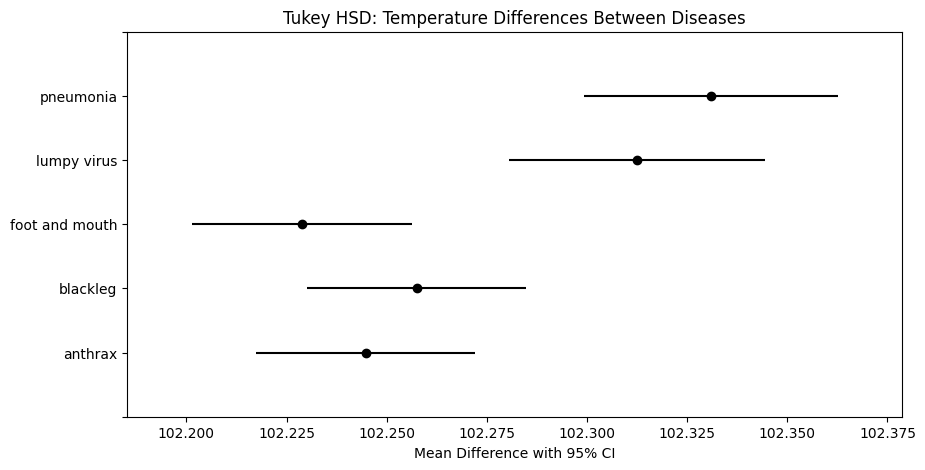

In [6]:
import statsmodels.stats.multicomp as mc

tukey_tst = adisease[["Temperature", "Disease"]]

tukey_result = mc.pairwise_tukeyhsd(
    endog=tukey_tst["Temperature"],  
    groups=tukey_tst["Disease"],      
    alpha=0.05                       
)


print(tukey_result.summary())

tukey_result.plot_simultaneous(figsize=(10, 5))
plt.title("Tukey HSD: Temperature Differences Between Diseases")
plt.xlabel("Mean Difference with 95% CI")
plt.show()

#Prepare Data for Machine Learning

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer

#Merge symptoms into a single list per row
symptom_cols = ["Symptom 1", "Symptom 2", "Symptom 3"]
adisease["All_Symptoms"] = adisease[symptom_cols].values.tolist()
adisease["All_Symptoms"] = adisease["All_Symptoms"].apply(lambda x: list(set(x)))

#One-hot encode the unique symptoms
mlb = MultiLabelBinarizer()
symptom_dummies = pd.DataFrame(
    mlb.fit_transform(adisease["All_Symptoms"]),
    columns=mlb.classes_,
    index=adisease.index
)

#One-hot encode Animal column
animal_dummies = pd.get_dummies(adisease["Animal"])
animal_dummies.columns = [col.replace("Animal_", "") for col in animal_dummies.columns] 


traindata = pd.concat([
    adisease[["Age", "Temperature"]],
    symptom_dummies,
    animal_dummies
], axis=1)

# Encode target column (Disease)
revd = LabelEncoder()
traindata["Disease"] = revd.fit_transform(adisease["Disease"])

#Split Data Into Training and Testing Sets; Scale Features

In [8]:
from sklearn.model_selection import train_test_split

# Select features (all except Disease) and target (Disease)
X = traindata.drop("Disease", axis=1)
y = traindata["Disease"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler
# Scale features using StandardScaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

#Train Random Forest Classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#Evaluate Model Performance

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=revd.classes_))



Accuracy: 0.8056190041114665

Classification Report:
                 precision    recall  f1-score   support

       anthrax       1.00      1.00      1.00      1972
      blackleg       1.00      1.00      1.00      1963
foot and mouth       1.00      1.00      1.00      1963
   lumpy virus       0.41      0.40      0.40      1443
     pneumonia       0.40      0.41      0.40      1415

      accuracy                           0.81      8756
     macro avg       0.76      0.76      0.76      8756
  weighted avg       0.81      0.81      0.81      8756



#Confusion Matrix

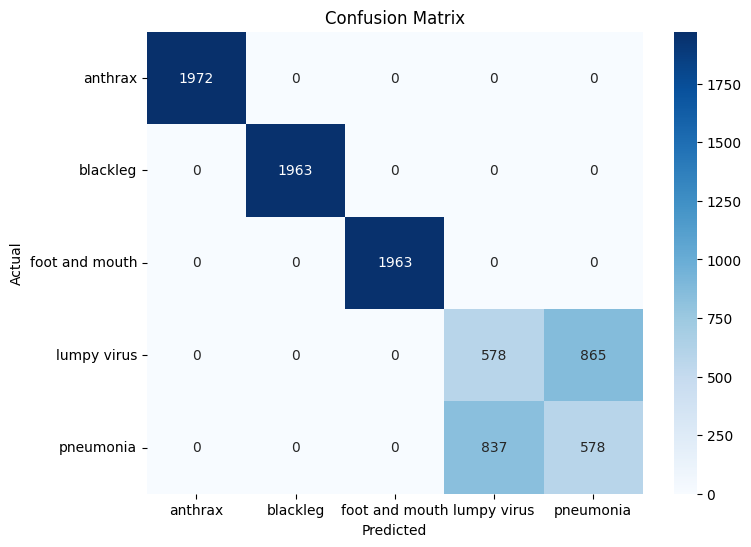

In [11]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=revd.classes_, yticklabels=revd.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#Feature Importance Analysis

                    Feature  Importance
14           painless lumps    0.173220
9                depression    0.134786
13         loss of appetite    0.130566
8           crackling sound    0.129005
1               Temperature    0.057860
23         swelling in limb    0.043539
24       swelling in muscle    0.042747
15      shortness of breath    0.037153
12                 lameness    0.035429
7                    chills    0.035230
11                  fatigue    0.033850
10       difficulty walking    0.033276
20                   sweats    0.030128
6          chest discomfort    0.024536
0                       Age    0.018061
21      swelling in abdomen    0.005609
18           sores on mouth    0.004504
19          sores on tongue    0.004481
25         swelling in neck    0.003834
16            sores on gums    0.003787
22  swelling in extremities    0.003458
3        blisters on hooves    0.003136
5        blisters on tongue    0.003004
4         blisters on mouth    0.002944


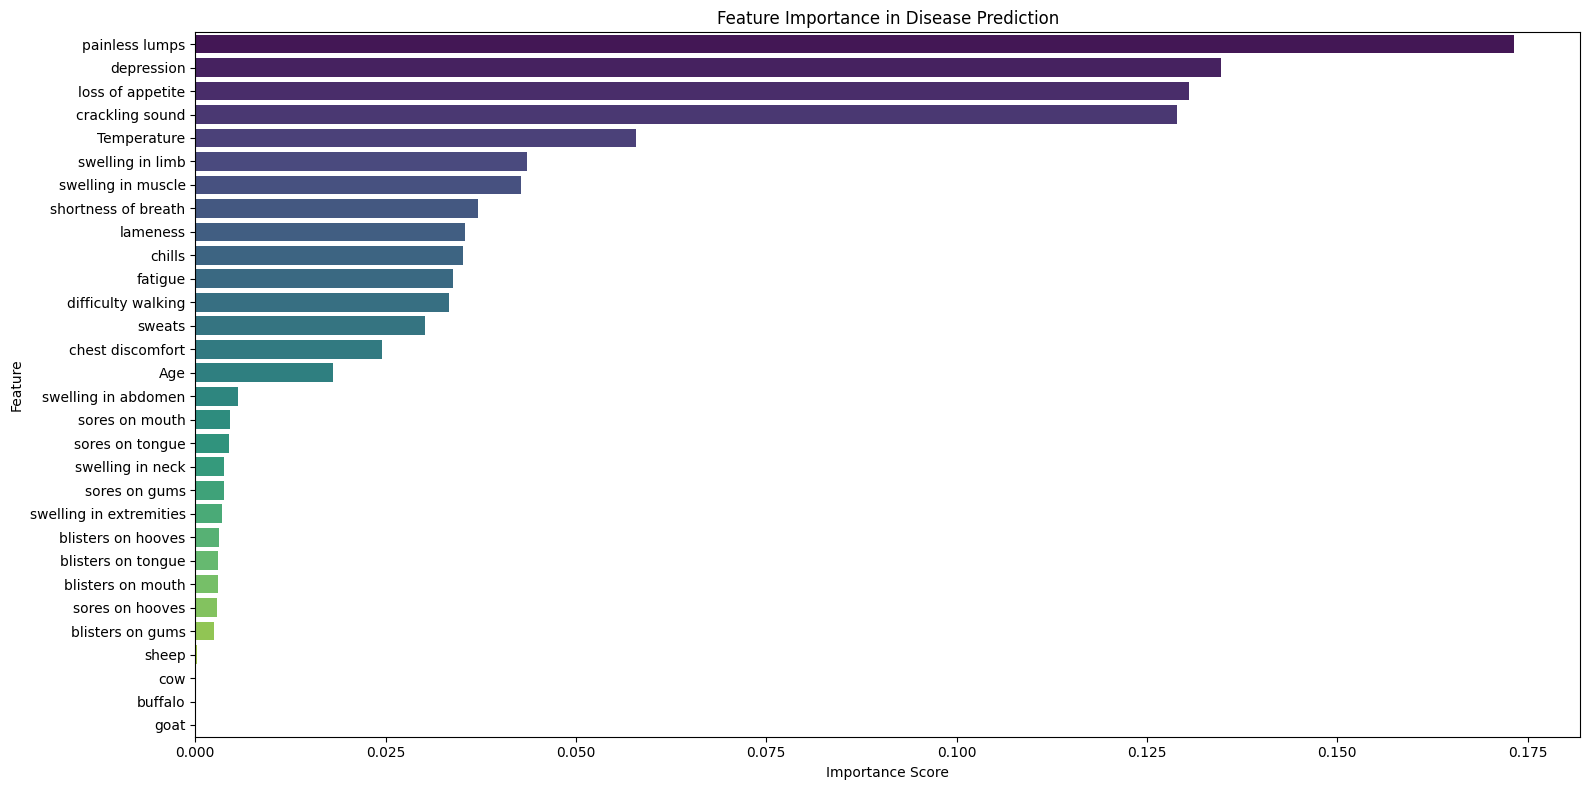

In [12]:
feature_names = X.columns

# Extract importances
importances = model.feature_importances_

# Create a DataFrame for easy visualization
feat_imp_d = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Print sorted importances
print(feat_imp_d)

plt.figure(figsize=(16, 8))
sns.barplot(data=feat_imp_d, x="Importance", y="Feature", hue= "Feature", palette="viridis")
plt.title("Feature Importance in Disease Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression for multiclass classification
log_model = LogisticRegression(solver='lbfgs', max_iter=5000)

# Fit model
log_model.fit(X_train, y_train)

from sklearn.metrics import classification_report, accuracy_score

# Predict
y_pred = log_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=revd.classes_))

Accuracy: 0.8329145728643216

Classification Report:
                 precision    recall  f1-score   support

       anthrax       1.00      1.00      1.00      1972
      blackleg       1.00      1.00      1.00      1963
foot and mouth       1.00      1.00      1.00      1963
   lumpy virus       0.48      0.14      0.22      1443
     pneumonia       0.49      0.84      0.62      1415

      accuracy                           0.83      8756
     macro avg       0.79      0.80      0.77      8756
  weighted avg       0.83      0.83      0.81      8756



#Logistic Regression Coefficients


Logistic Regression Coefficients by Disease

          Disease       Age  Temperature  blisters on gums  \
0         anthrax -0.001311    -0.004592         -0.081025   
1        blackleg  0.016390    -0.042664         -0.625366   
2  foot and mouth -0.004643    -0.005061          1.017555   
3     lumpy virus -0.013790     0.023429         -0.155431   
4       pneumonia  0.003354     0.028888         -0.155733   

   blisters on hooves  blisters on mouth  blisters on tongue  \
0           -0.082991          -0.081273           -0.081309   
1           -0.640557          -0.626915           -0.627596   
2            1.042383           1.020015            1.021300   
3           -0.159171          -0.155706           -0.155989   
4           -0.159663          -0.156121           -0.156407   

   chest discomfort    chills  crackling sound  ...    sweats  \
0          0.850873  0.842258        -0.088375  ...  0.852224   
1         -0.419967 -0.415465         1.710889  ... -0.420635   
2

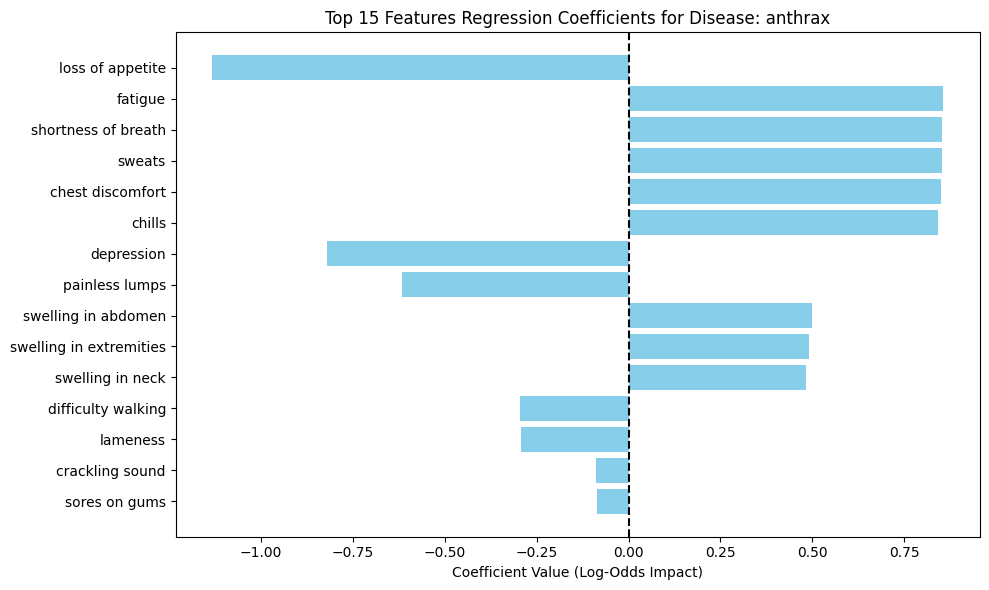

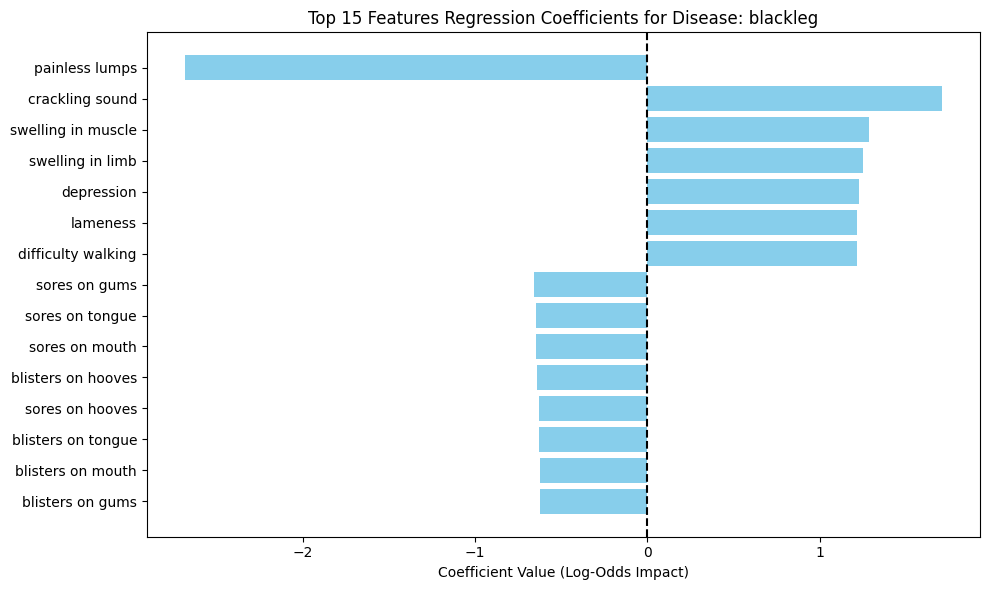

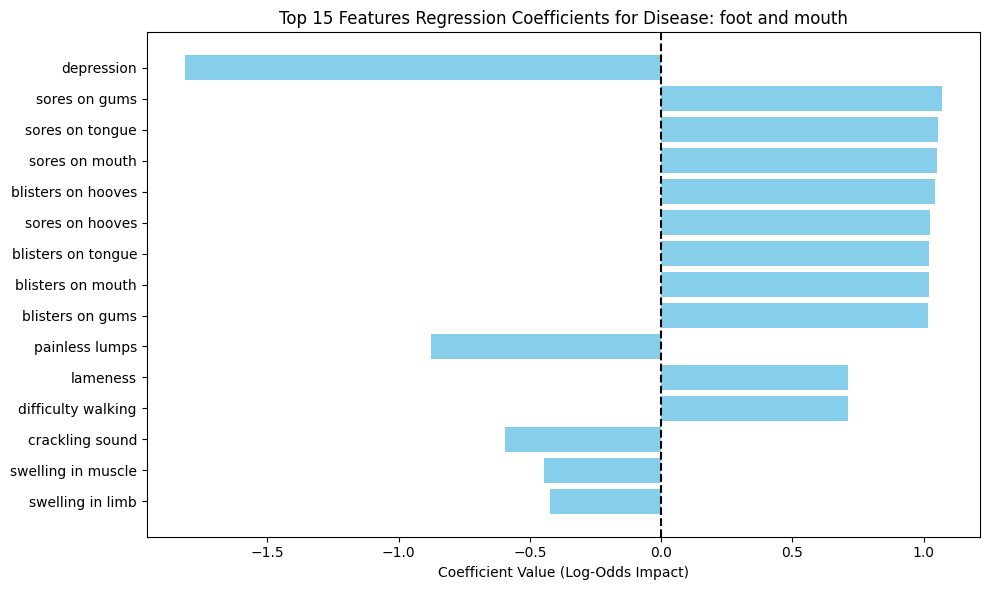

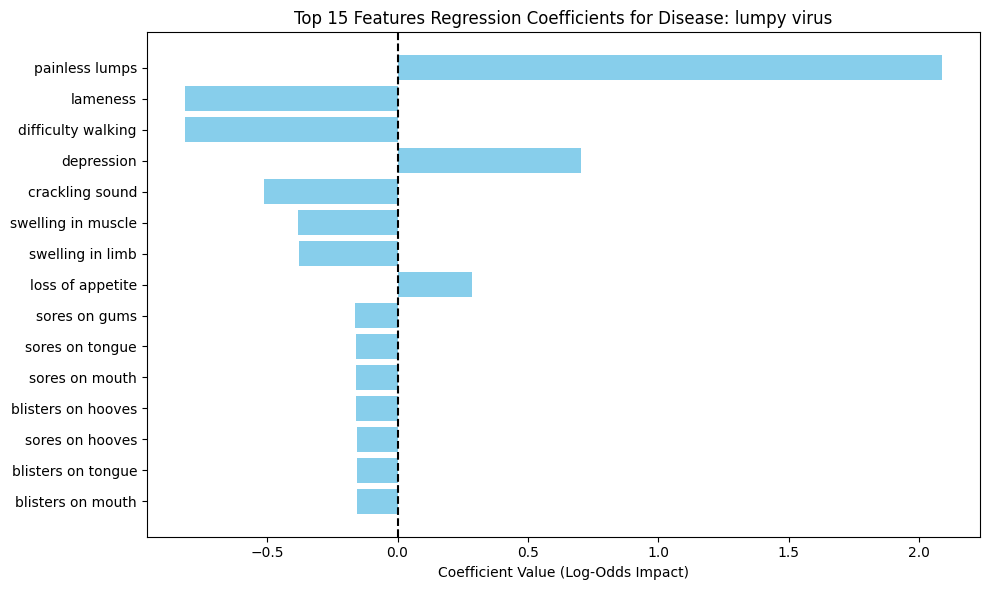

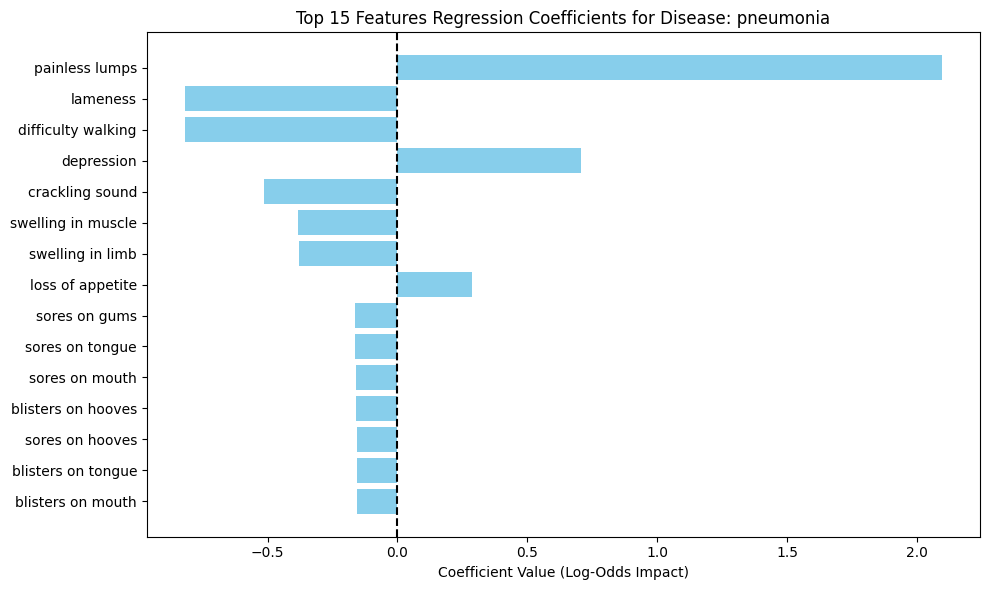

In [14]:
# Create a DataFrame of coefficients
coeff_disease = pd.DataFrame(log_model.coef_, columns=feature_names)
coeff_disease["Disease"] = revd.classes_
coeff_disease = coeff_disease[["Disease"] + list(feature_names)]

print("\nLogistic Regression Coefficients by Disease\n")
print(coeff_disease)

for i, disease in enumerate(revd.classes_):
    coef_values = log_model.coef_[i]

    coef_subset = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coef_values
    }).sort_values("Coefficient", key=abs, ascending=False)


    plt.figure(figsize=(10, 6))
    plt.barh(coef_subset["Feature"][:15], coef_subset["Coefficient"][:15], color="skyblue")
    plt.axvline(0, color="black", linestyle="--")
    plt.title(f"Top 15 Features Regression Coefficients for Disease: {disease}")
    plt.xlabel("Coefficient Value (Log-Odds Impact)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


Summary plot for anthrax


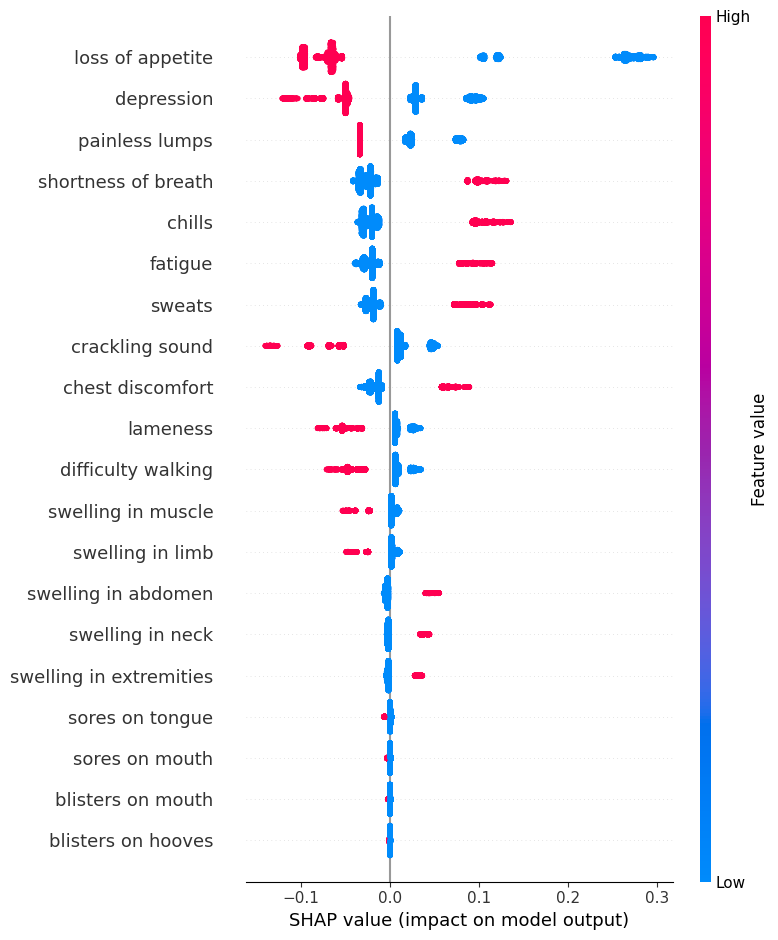


Summary plot for blackleg


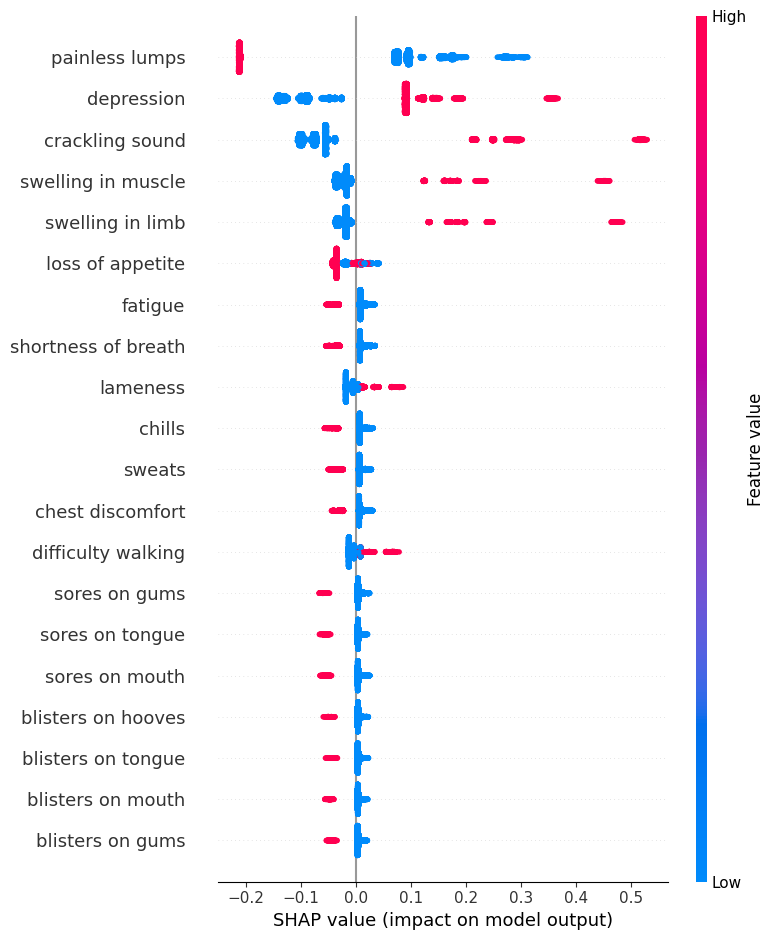


Summary plot for foot and mouth


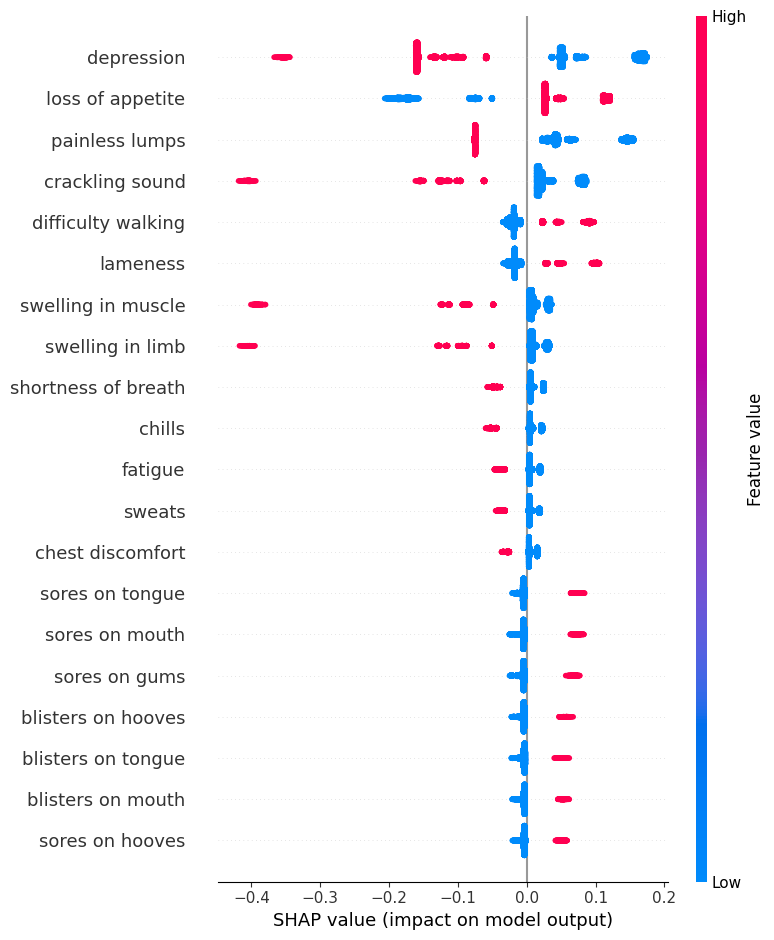


Summary plot for lumpy virus


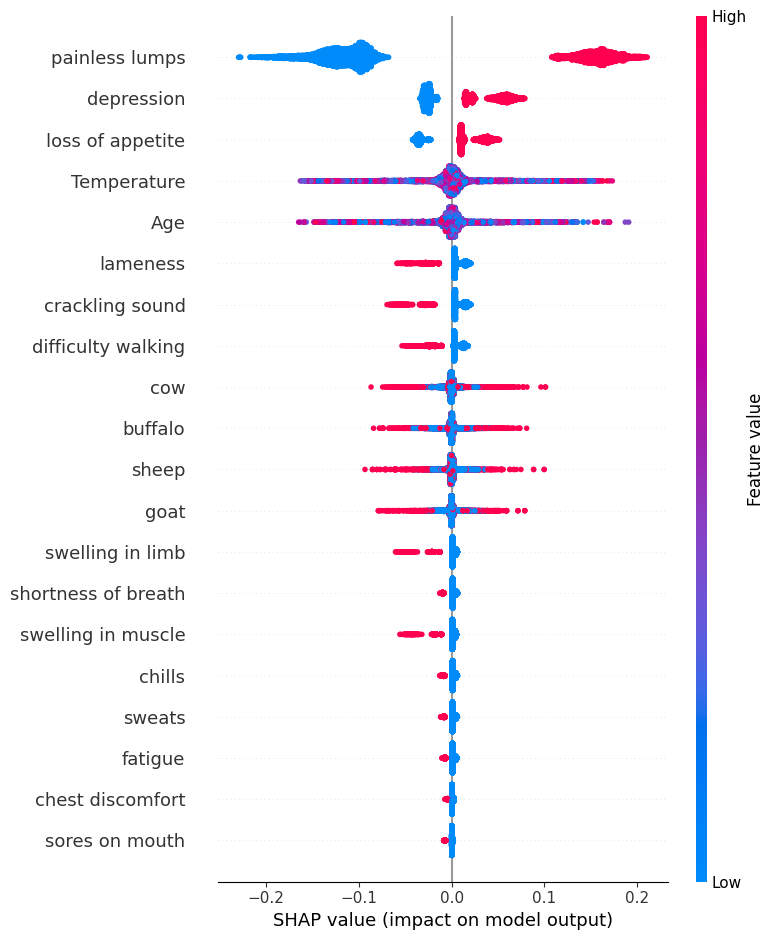


Summary plot for pneumonia


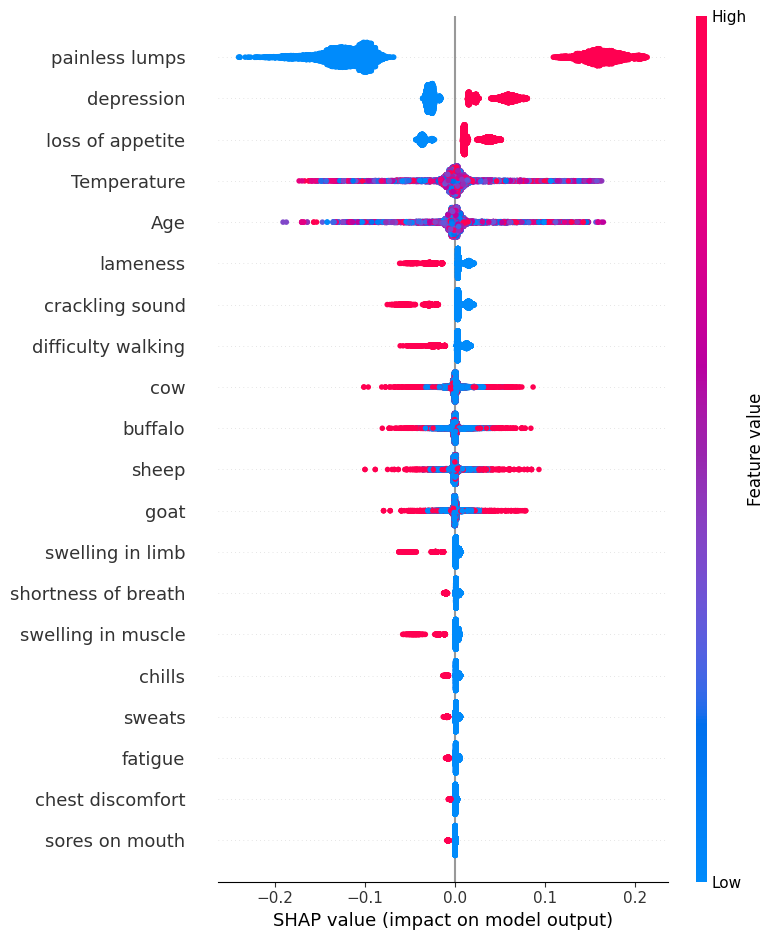


Waterfall plot for predicted class: anthrax


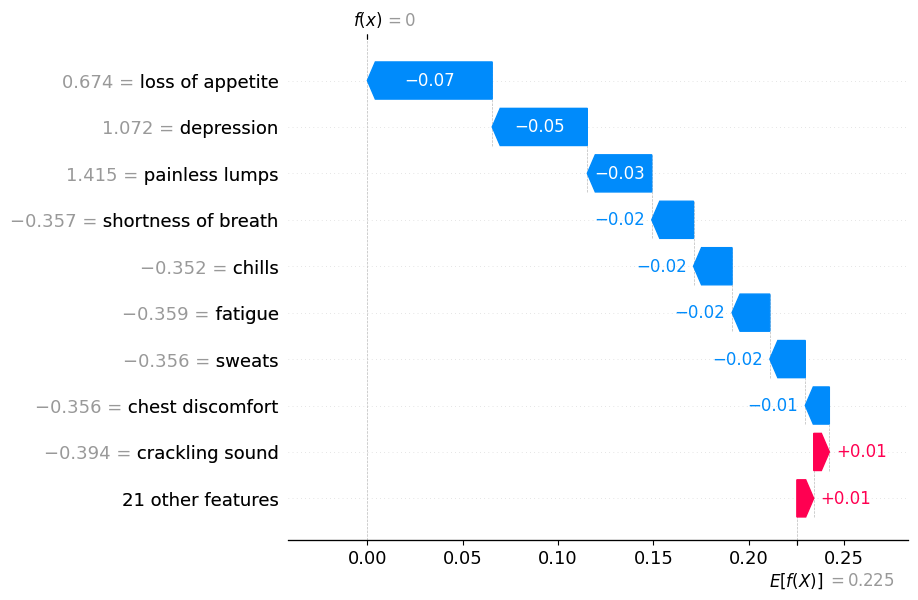


Waterfall plot for predicted class: blackleg


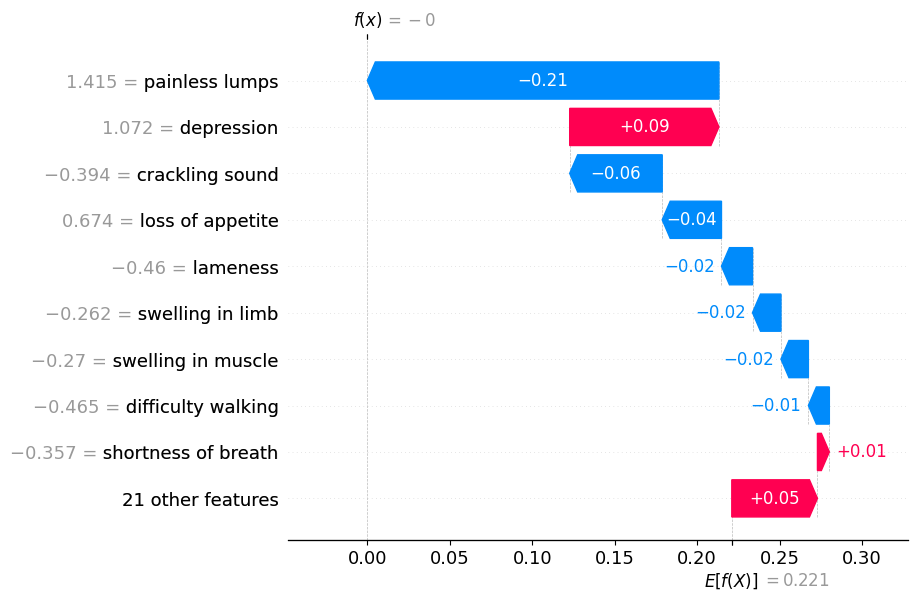


Waterfall plot for predicted class: foot and mouth


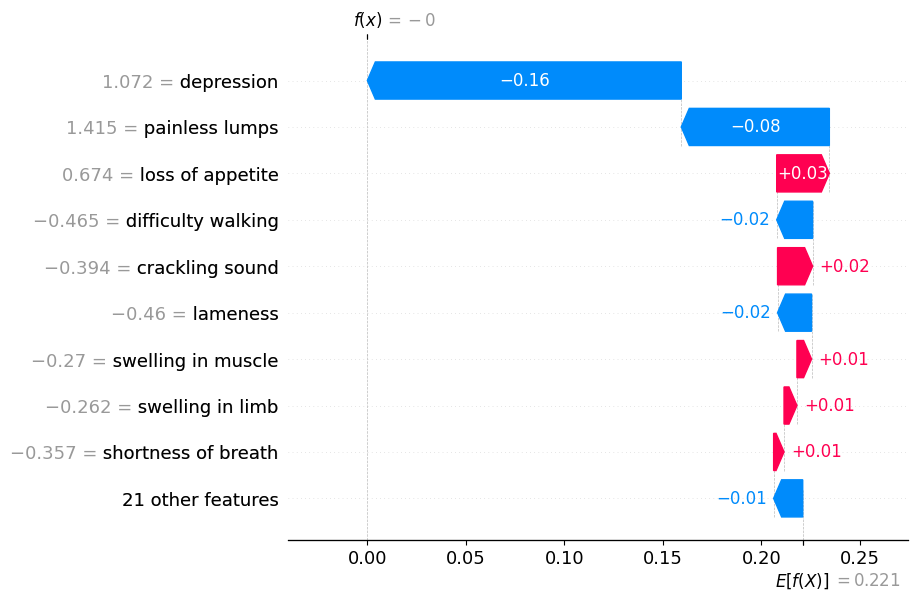


Waterfall plot for predicted class: lumpy virus


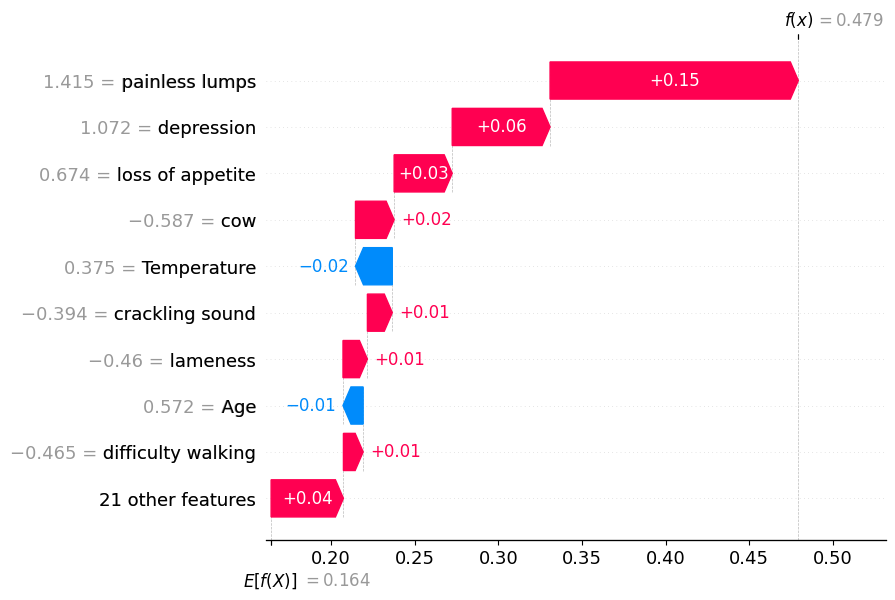


Waterfall plot for predicted class: pneumonia


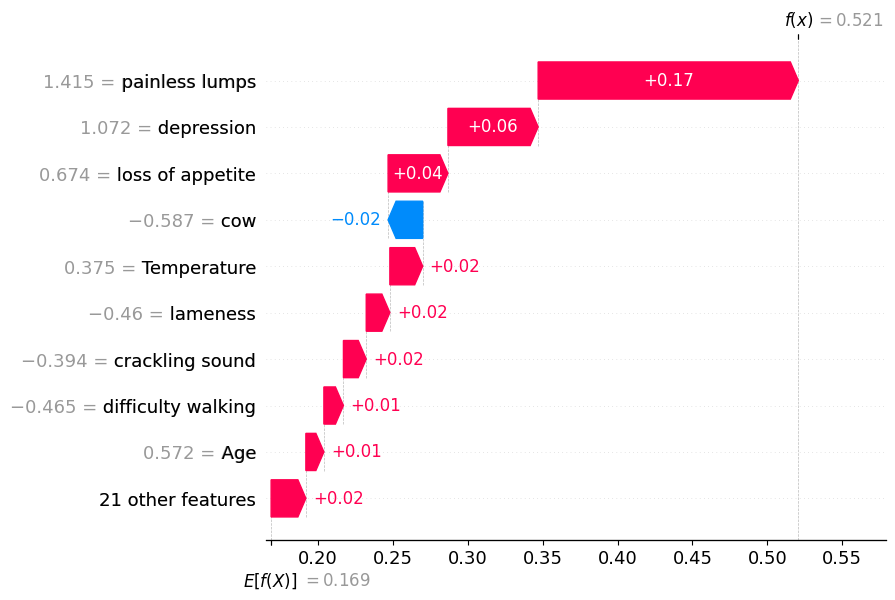

In [16]:
import shap

shap.initjs()

# SHAP Explainer
explainer = shap.TreeExplainer(model)
shap_values_raw = explainer.shap_values(X_test)

# Convert raw values to per-class SHAP values
shap_values = [shap_values_raw[:, :, i] for i in range(shap_values_raw.shape[2])]

# Summary plots for each disease
for i, name in enumerate(revd.classes_):
    print(f"\nSummary plot for {name}")
    shap.summary_plot(shap_values[i], X_test, plot_type="dot", class_names=revd.classes_)

#Waterfall plots
sample_index = 0
sample = X_test.iloc[sample_index]

for class_idx, class_name in enumerate(revd.classes_):
    print(f"\nWaterfall plot for predicted class: {class_name}")
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[class_idx][sample_index],
            base_values=explainer.expected_value[class_idx],
            data=sample,
            feature_names=X_test.columns
        )
    )